<a href="https://colab.research.google.com/github/emsmullen/VirtueSemantics/blob/main/VirtueSemantics_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Set Up

In [ ]:
#import packages
#hi here's a new message
#ok and the next one
#and the next one
import sys, os, random, requests, json #connects with interpreter; interacts with os; HTTP requests; JSON data
import pandas as pd #data structures and analysis tools
import numpy as np #for multi-dimensional data and mathematical functions (arrays)
import scipy.stats as st #complex computations (numerical)
import matplotlib.pyplot as plt #for plotting data
import sklearn.decomposition #for PCA
from google.colab import drive, data_table, userdata #access Google Drive; interactive pandas dataframes; secrets

In [ ]:
#set up paths for local modules and data sources
drive.mount('/content/drive',force_remount=True)
sys.path.append('/content/drive/MyDrive/')
stim_path = '/content/drive/MyDrive/'

Mounted at /content/drive


In [ ]:
#set environment variable with API key
%env OPENAI_API_KEY = userdata.get('OAI') #APIs connect software applications

env: OPENAI_API_KEY=userdata.get('OAI') #APIs connect software applications


In [ ]:
#read in stimuli stored on google drive (must add this file to drive)
#action_data = pd.read_csv(stim_path+"ValueSemantics/actions_human_complete.csv")
action_data = pd.read_csv(stim_path+"ValueSemantics/action_neurips.csv")
action_list_all = action_data["actions"].tolist()
#action_list_all = action_data[:,0].tolist()
n_items = len(action_list_all)

virtue_data = pd.read_csv(stim_path+"ValueSemantics/excess_deficiency_mean.csv")
virtue_list_all = virtue_data["excess"].tolist() + virtue_data["deficiency"].tolist() + virtue_data["mean"].tolist()
n_virtues = len(virtue_list_all)

In [ ]:
excess_list = virtue_data["excess"].tolist()
deficiency_list = virtue_data["deficiency"].tolist()
mean_list = virtue_data["mean"].tolist()
virtue_data

,excess,mean,deficiency
0,rashness,courage,cowardice
1,licentiousness,temperance,insensibility
2,prodigality,liberality,meanness
3,vulgarity,magnificence,pettiness
4,vanity,magnanimity,pusillanimity
5,empty vanity,pride,unambitiousness
6,irascibility,patience,lack of spirit
7,boastfulness,truthfulness,mock modesty
8,buffoonery,wittiness,boorishness
9,obsequiousness,friendliness,cantankerousness


# Embedding Projections

In [ ]:
#@title define functions
def getEmbeddings(text):
    url = 'https://api.openai.com/v1/embeddings'
    headers = {
      "Content-Type": "application/json",
      "Authorization": userdata.get('OAI')
      }
    data = {
        "input": text,
        "model": "text-embedding-ada-002"
    }
    response = requests.post(url, headers=headers, json=data)

    return response.json()

#function to get the difference of embeddings of two texts
def return_embeddings_diff(attributes_a, attributes_b):
  '''
  Pass two sets of attributes and get all vector differences of all a-b combinations
  NOTE: The distinction between high and low embeddings is automatically made by given data
  '''
  emb_high = pd.DataFrame()
  emb_low = pd.DataFrame()

  #loop through each attribute set and save the embeddings in two dataframes
  for a in range(len(attributes_a)):
    #get embedding of the high, low, and compute difference
    this_emb = getEmbeddings(attributes_a[a])
    emb_high.insert(loc=0, column=a, value=this_emb["data"][0]["embedding"])

  for b in range(len(attributes_b)):
    #get embedding of the high, low, and compute difference
    this_emb = getEmbeddings(attributes_b[b])
    emb_low.insert(loc=0, column=b, value=this_emb["data"][0]["embedding"])

  #get all differences
  vector_diff = pd.DataFrame()

  #report correlations
  print(emb_low.corr()) #correlations are higher when closer to 1
  print(emb_high.corr())

  for a in range(len(attributes_a)):
    for b in range(len(attributes_b)):
      this_col = str(a)+'_'+str(b)
      vector_diff.insert(loc=0, column=this_col, value=emb_high[a] - emb_low[b])

  return(vector_diff.mean(axis=1)) #pandas series; contains average value per row for overall differences in embeddings


def return_list_embeddings(alist):
  '''
  get embeddings for a list of items
  '''
  n_df = pd.DataFrame()
  for i in alist:
    this_em = getEmbeddings(i)["data"][0]["embedding"]
    n_df.insert(loc=0, column=i, value=this_em, allow_duplicates=True)

  return (n_df)


def get_projections(stim_list, moral_v, hedonic_v, movement_v):
  '''
  get projections for list of items
  '''
  #construct dataframe to save items
  projection_df = pd.DataFrame(index=stim_list, columns=['moral_v','hedonic_v','movement_v'], data=0)

  #loop through items to get embeddings in moral, hedonic, and movement vector directions

  for a in stim_list:
    this_em = getEmbeddings(a)["data"][0]["embedding"]
    projection_moral = np.inner(np.array(this_em),np.array(moral_v))
    projection_hedonic = np.inner(np.array(this_em),np.array(hedonic_v))
    projection_movement = np.inner(np.array(this_em),np.array(movement_v))
    projection_df.loc[a, "moral_v"] = projection_moral
    projection_df.loc[a, "hedonic_v"] = projection_hedonic
    projection_df.loc[a, "movement_v"] = projection_movement

  return projection_df

In [ ]:
virtue_embeddings = return_list_embeddings(virtue_list_all)

In [ ]:
virtue_embeddings

,righteous indignation,modesty,friendliness,wittiness,truthfulness,patience,pride,magnanimity,magnificence,liberality,...,obsequiousness,buffoonery,boastfulness,irascibility,empty vanity,vanity,vulgarity,prodigality,licentiousness,rashness
0,-0.011200,-0.002438,0.004982,-0.008253,-0.010826,-0.004526,0.000002,-0.004681,-0.008041,-0.005600,...,-0.029072,-0.039844,-0.019953,-0.018716,-0.007868,-0.004206,-0.004958,0.000680,0.005233,0.020570
1,-0.016460,-0.011328,-0.001430,-0.008199,-0.012531,0.000872,-0.023082,-0.017111,0.007849,-0.014227,...,-0.005782,-0.013117,0.005599,-0.008635,-0.005754,-0.010891,-0.008772,-0.041449,0.008762,0.009405
2,-0.005365,0.004673,0.005881,0.001512,-0.005146,0.003711,0.008849,0.019226,0.018468,-0.003365,...,0.005070,0.026140,0.019859,0.013484,0.013062,0.027552,0.016558,-0.002456,0.014844,0.013400
3,-0.025483,-0.017756,-0.025036,-0.007872,-0.020114,-0.029560,-0.031573,-0.030045,-0.037228,-0.040953,...,-0.020626,-0.008166,-0.027910,-0.035235,0.017285,-0.021650,-0.004324,-0.032974,-0.043192,-0.030156
4,-0.012689,-0.022807,0.007567,-0.004410,-0.005239,0.006512,0.006235,-0.004956,0.005353,-0.018043,...,0.001490,-0.012750,-0.002643,-0.011455,-0.040163,-0.022623,-0.019148,-0.020084,-0.002985,-0.004924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531,0.056259,0.045173,0.037464,0.057476,0.015701,0.019887,0.045696,0.086665,0.056267,0.041091,...,0.048322,0.056683,0.059791,0.024410,0.032858,0.026395,0.026879,0.056138,0.047603,0.042240
1532,-0.004270,-0.008217,0.015217,0.004771,-0.000435,0.015902,0.007445,-0.001819,-0.000325,0.000922,...,-0.002687,-0.004420,-0.011902,0.031859,-0.024739,-0.004745,-0.000353,0.002228,0.015696,0.018865
1533,-0.009368,-0.005640,-0.027110,-0.019537,-0.001844,-0.008729,-0.028843,-0.031862,-0.024567,-0.025233,...,-0.012908,-0.001076,-0.026447,-0.014804,-0.013822,-0.013099,-0.030511,-0.017536,-0.019959,-0.030774
1534,0.010565,0.002448,-0.001856,0.004580,0.016369,0.016720,0.020715,0.002339,-0.003384,0.018306,...,0.011240,0.013037,0.019094,0.012754,0.010231,0.008157,0.014200,0.025616,0.030391,0.020623


## generate embeddings

In [ ]:
#virtues_PCA = sklearn.decomposition.PCA(virtue_embeddings,n_components=3)
pca = sklearn.decomposition.PCA(n_components=3)
pca.fit(virtue_embeddings)
print(pca.explained_variance_ratio_)
pca.fit_transform(virtue_embeddings)

NameError: name 'sklearn' is not defined

In [ ]:
# get moral direction in GPT embeddings
attributes_morality_high = ['morally virtuous','ethical', 'high moral value']
attributes_morality_low = ['morally wrong','unethical', 'low moral value']
moral_v = return_embeddings_diff(attributes_morality_high, attributes_morality_low)

# get hedonic direction in GPT embeddings
attributes_hedonic_high = ['personally rewarding','pleasurable for me', 'high hedonic value for me']
attributes_hedonic_low = ['personally costly','unpleasurable for me', 'low hedonic value for me']
hedonic_v = return_embeddings_diff(attributes_hedonic_high, attributes_hedonic_low)

# get physicality direction in GPT embeddings
attributes_movement_high = ['physical','bodily action', 'high movement']
attributes_movement_low = ['mental','minimally active', 'low movement']
movement_v = return_embeddings_diff(attributes_movement_high, attributes_movement_low)


          2         1         0
2  1.000000  0.849759  0.875315
1  0.849759  1.000000  0.893319
0  0.875315  0.893319  1.000000
          2         1         0
2  1.000000  0.833950  0.891547
1  0.833950  1.000000  0.831318
0  0.891547  0.831318  1.000000
          2         1         0
2  1.000000  0.856273  0.806584
1  0.856273  1.000000  0.804478
0  0.806584  0.804478  1.000000
          2         1         0
2  1.000000  0.881714  0.822901
1  0.881714  1.000000  0.844764
0  0.822901  0.844764  1.000000
          2         1         0
2  1.000000  0.849063  0.759322
1  0.849063  1.000000  0.760345
0  0.759322  0.760345  1.000000
          2         1         0
2  1.000000  0.795824  0.783809
1  0.795824  1.000000  0.842920
0  0.783809  0.842920  1.000000


In [ ]:
# Report correlation among attribute embeddings
print('Embedding Correlations:')
print('r(moral, hedonic) = '+ str(round(np.corrcoef(moral_v, hedonic_v)[0, 1], 2)))
print('r(moral, movement) = '+ str(round(np.corrcoef(moral_v, movement_v)[0, 1], 2)))
print('r(hedonic, movement) = '+ str(round(np.corrcoef(hedonic_v, movement_v)[0, 1], 2)))


## generate projections on embeddings

In [ ]:
# get projections of stimuli onto each vector direction
#item_projections = get_projections(action_list_all, moral_v, hedonic_v, movement_v, social_v)
excess_projections = get_projections(excess_list, moral_v, hedonic_v, movement_v)
deficiency_projections = get_projections(deficiency_list, moral_v, hedonic_v, movement_v)
mean_projections = get_projections(mean_list, moral_v, hedonic_v, movement_v)

item_projections["item"] = item_projections.index

<ipython-input-81-9a4e52498519>:77: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.008128498181515299' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  projection_df.loc[a, "moral_v"] = projection_moral
<ipython-input-81-9a4e52498519>:78: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.00906591482654647' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  projection_df.loc[a, "hedonic_v"] = projection_hedonic
<ipython-input-81-9a4e52498519>:79: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.02234547954340919' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  projection_df.loc[a, "movement_v"] = projection_movement
<ipython-

In [ ]:
excess_projections["moral_v"]

,moral_v
rashness,-0.008128
licentiousness,-0.013024
prodigality,0.002157
vulgarity,-0.020713
vanity,0.014390
ambition,0.022900
irascibility,0.007597
boastfulness,0.028848
buffoonery,-0.024381
obsequiousness,0.017199


In [ ]:
data = {'excess': virtue_data['excess'],
        'excess value': excess_projections['moral_v'].tolist(),
        'mean': virtue_data['mean'],
        'mean value': mean_projections['moral_v'].tolist(),
        'deficiency': virtue_data['deficiency'],
        'deficiency value': deficiency_projections['moral_v'].tolist()
}


NameError: name 'virtue_data' is not defined

In [ ]:
df = pd.DataFrame(data)
df

,excess,excess value,mean,mean value,deficiency,deficiency value
0,rashness,-0.008128,courage,0.033223,cowardice,-0.015978
1,licentiousness,-0.013024,temperance,0.030826,insensibility,-0.020047
2,prodigality,0.002157,liberality,0.028609,meanness,-0.017838
3,vulgarity,-0.020713,magnificence,0.037803,pettiness,-0.018463
4,vanity,0.014390,magnanimity,0.039045,pusillanimity,0.013066
5,ambition,0.022900,pride,0.033071,unambitiousness,-0.008197
6,irascibility,0.007597,patience,0.026559,unirascibility,0.005336
7,boastfulness,0.028848,truthfulness,0.033105,understatement,-0.021524
8,buffoonery,-0.024381,wittiness,0.020567,boorishness,-0.012465
9,obsequiousness,0.017199,friendliness,0.032258,cantankerousness,0.008617


<ipython-input-16-36cdd83c0fbc>:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(plot_i, (item_projections_1['hedonic_v'][i]+.0005, item_projections_1['moral_v'][i]-.0001))


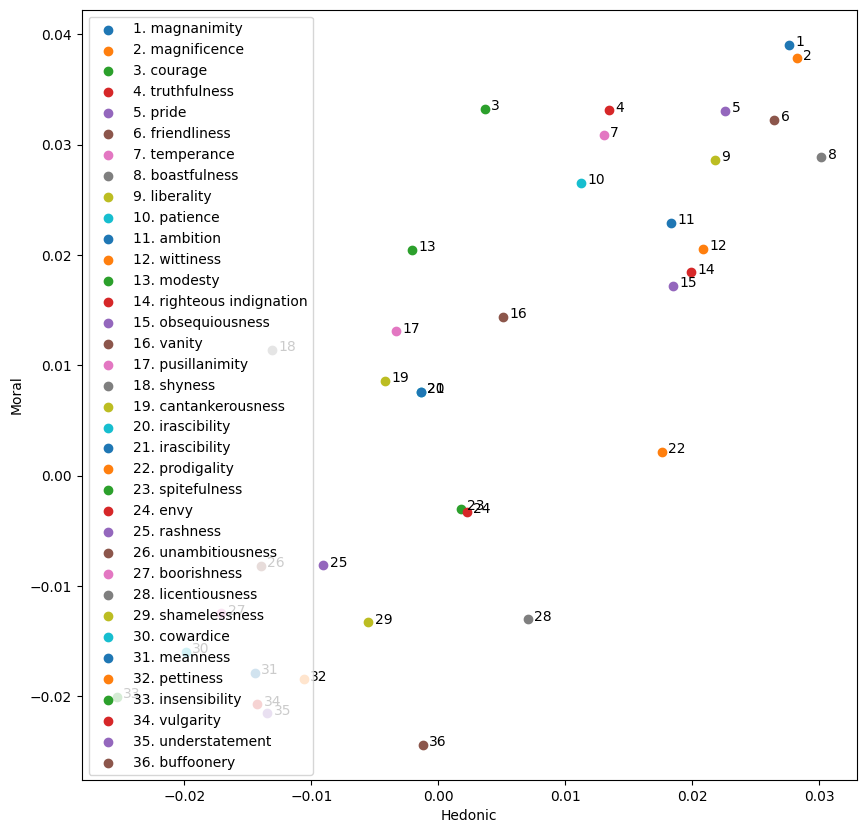

In [ ]:
# Plot Embeddings for Moral x Hedonic

# sort projections by morality before plotting
item_projections_1 = item_projections.sort_values('moral_v', ascending=False)


fig, ax = plt.subplots(figsize=(10, 10))
cmap = plt.get_cmap("tab20")

plot_i = 1
for i in range(len(item_projections_1)):
    x = item_projections_1['hedonic_v'].iloc[i]
    y = item_projections_1['moral_v'].iloc[i]
    colors = cmap(i/len(item_projections_1))
    l = str(plot_i) + '. ' + item_projections_1.index[i].lstrip('[').rstrip(']')
    ax.scatter([x],[y], label=l)
    ax.annotate(plot_i, (item_projections_1['hedonic_v'][i]+.0005, item_projections_1['moral_v'][i]-.0001))
    plot_i += 1

ax.set_xlabel('Hedonic')
ax.set_ylabel('Moral')
ax.legend()

# Sort-Rate Prompting (GPT-3.5)

In [ ]:
# @title define functions


def promptGPT(prompt_message_list, gpt_temperature=0):
  gpt_url = "https://api.openai.com/v1/chat/completions"
  gpt_headers = {
    "Content-Type": "application/json",
    "Authorization": userdata.get('OAI')
    }
  gpt_data = {
        "model": "gpt-3.5-turbo-1106",
        "response_format": {"type": "json_object"}, # only works on 3.5-turbo-1106, 4 and above
        "temperature": gpt_temperature,
        "messages": prompt_message_list,
    }
  response = requests.post(gpt_url, headers=gpt_headers, json=gpt_data)
  output = response.json()['choices'][0]['message']['content']

  return output

def prompt_sort(action_list, dimension, context=""):
  """
  Given a list of actions to sort, and a dimension to sort them on, craft a prompt
  for GPT, with example calls and responses.

  Optionally, include context regarding the hypothetical rater (Ziv),
  which may influence the ranking results.

  Returns a list of dicts to pass on to GPT as prompt messages
  """

  #randomize the order of the list
  random.shuffle(action_list)

  #turn list into formatted string
  action_string = (', ').join(action_list)

  # Switch by sorting dimension
  if dimension == 'moral':

    system_prompt_content = """You are an expert judge of the relative moral virtues of different actions.
Moral actions are those which humans consider virtuous, that consider others' wellbeing and happiness, and that are guided by principles of ethics.
You will be given a list of actions that an average human person, Ziv, is considering.
You must sort them in terms of their relative moral virtue according to Ziv.
You will recieve a JSON object of items to rate. This object will have the following key / value pairs:
1. actions - Array<string>: an unsorted list of actions that the user has been faced with
2. context - string: information that you can use to help you make your choice
You must respond with a JSON packet with a single key / value pair:
1. ranking - Array<string>: A sorted list of actions, starting with the most morally wrong, and ending with the most morally virtuous from Ziv's perpsective."""
    system_prompt= {
        "role": "system",
        "content": system_prompt_content
    }
    user_example = {
        "role": "user",
        "content": json.dumps({"actions": ["walk a dog", "rob a bank", "rescue a cat", "steal food"],
                               "context": ""}) # Initial example has no context
    }
    assistant_example = {
        "role": "assistant",
        "content": json.dumps({"ranking": ["rob a bank", "steal food", "walk a dog", "rescue a cat"]})
    }

  elif dimension == 'hedonic':

    system_prompt_content = """You are an expert judge of the relative hedonic reward of different actions.
Hedonically rewarding actions are those which humans consider pleasant, make them feel happy, and benefit their own wellbeing.
You will be given a list of actions that an average human person, Ziv, is considering.
You must sort them in terms of their relative hedonic reward for Ziv.
You will recieve a JSON object of items to rate. This object will have the following key / value pairs:
1. actions - Array<string>: an unsorted list of actions that the user has been faced with
2. context - string: information that you can use to help you make your choice
You must respond with a JSON packet with a single key / value pair:
1. ranking - Array<string>: A sorted list of actions, starting with the
worst and least hedonically rewarding, and ending with the best and most hedonically rewarding from Ziv's perpsective."""
    system_prompt= {
        "role": "system",
        "content": system_prompt_content
    }
    user_example = {
        "role": "user",
        "content": json.dumps({"actions": ["miss the bus", "win a sweepstakes", "eat a meal", "lose my wallet"],
                               "context": ""}) # Initial example has no context
    }
    assistant_example = {
        "role": "assistant",
        "content": json.dumps({"ranking": ["lose my wallet", "miss the bus", "eat a meal", "win a sweepstakes"]})
    }

  elif dimension == 'movement':

    system_prompt_content = """You are an expert judge of the physical body movement
of different actions. Physically active actions are those which humans consider to involve substantial movement of the body.
You will be given a list of actions that an average human person, Ziv, is considering.
You must sort them in terms of how much physical movement they involve.
You will recieve a JSON object of items to rate. This object will have the following key / value pairs:
1. actions - Array<string>: an unsorted list of actions that the user has been faced with
2. context - string: information that you can use to help you make your choice
You must respond with a JSON packet with a single key / value pair:

1. ranking - Array<string>: A sorted list of actions, starting with the
least physical body movement, and ending with the most physical body movement."""
    system_prompt= {
        "role": "system",
        "content": system_prompt_content
    }
    user_example = {
        "role": "user",
        "content": json.dumps({"actions": ["play soccer", "listen to music", "pack boxes", "order coffee at a cafe"],
                               "context": ""}) # Initial example has no context
    }
    assistant_example = {
        "role": "assistant",
        "content": json.dumps({"ranking": ["listen to music", "order coffee at a cafe", "pack boxes", "play soccer"]})
    }

  else:
    raise Exception("Specify a rating dimension: moral, hedonic, movement")


  # List actions to sort
  user_prompt = {
      "role": "user",
      "content": json.dumps({"actions": action_list,
                             "context": context}) # Optional context, defaults to empty string
  }

  return [system_prompt, user_example, assistant_example, user_prompt]


def prompt_rate_sorted(action_list, dimension, context=""):
  """
  Given a sorted list of actions to rate, and a dimension to sort them on, craft a prompt
  for GPT, with example calls and responses.

  Optionally, include context regarding the hypothetical rater (Ziv),
  which may influence the rating results.

  Returns a list of dicts to pass on to GPT as prompt messages
  """

  #turn list into formatted string
  action_string = (', ').join(action_list)

  # Switch by sorting dimension
  if dimension == 'moral':

    system_prompt_content = """You are an expert judge of the relative moral virtues of different actions.
Moral actions are those which humans consider virtuous, that consider others' wellbeing and happiness, and that are guided by principles of ethics.
You will be given a list of actions that an average human person, Ziv, is considering.
They are already sorted in terms of their relative moral virtue according to Ziv.
You will assign a number to each adjacent pair, rating 0 if the actions are very similar in terms of moral virtue, and 10 if the actions are very different in terms of moral virtue.
You will give the first action a rating of 0. You will give the second action a rating in comparison to the first action, and so on.
You will recieve a JSON object of items to rate. This object will have the following key / value pairs:
1. actions - Array<string>: a sorted list of actions that the user has been faced with
2. context - string: information that you can use to help you make your choice
You must respond with a JSON packet with a single key / value pair:
1. ranking - Array: A list of lists, each list contains 2 elements:
1. action from the original list
2. similarity rating from 0 to 10 between this action and the previous action in the list"""

    system_prompt= {
        "role": "system",
        "content": system_prompt_content
    }
    user_example = {
        "role": "user",
        "content": json.dumps({"actions": ["rob a bank", "steal food", "walk a dog", "rescue a cat"],
                               "context": ""}) # Initial example has no context
    }
    assistant_example = {
        "role": "assistant",
        "content": json.dumps({"ranking": [["rob a bank", 0], ["steal food", 3], ["walk a dog", 10], ["rescue a cat", 6]]})
    }

  elif dimension == 'hedonic':

    system_prompt_content = """You are an expert judge of the relative hedonic reward
of different actions. Hedonically rewarding actions are those which humans consider pleasant, make them feel happy, and benefit their own wellbeing.
You will be given a list of actions that an average human person, Ziv, is considering.
They are already sorted in terms of their relative hedonic reward for Ziv.
You will assign a number to each adjacent pair, rating 0 if the actions are very similar
in terms of hedonic reward, and 10 if the actions are very different in terms of hedonic reward.
You will give the first action a rating of 0. You will give the second action a rating in comparison to the first action, and so on.
You will recieve a JSON object of items to rate. This object will have the following key / value pairs:
1. actions - Array<string>: a sorted list of actions that the user has been faced with
2. context - string: information that you can use to help you make your choice
You must respond with a JSON packet with a single key / value pair:
1. ranking - Array: A list of lists, each list contains 2 elements:
1. action from the original list
2. similarity rating from 0 to 10 between this action and the previous action in the list"""

    system_prompt= {
        "role": "system",
        "content": system_prompt_content
    }
    user_example = {
        "role": "user",
        "content": json.dumps({"actions": ["lose my wallet", "miss the bus", "eat a meal", "win a sweepstakes"],
                               "context": ""}) # Initial example has no context
    }
    assistant_example = {
        "role": "assistant",
        "content": json.dumps({"ranking": [["lose my wallet", 0], ["miss the bus", 2], ["eat a meal", 9], ["win a sweepstakes", 8]]})
    }

  elif dimension == 'movement':

    system_prompt_content = """You are an expert judge of the physical body movement of different actions.
Physically active actions are those which humans consider to involve substantial movement of the body.
You will be given a list of actions that an average human person, Ziv, is considering.
They are already sorted in terms of how much physical movement they involve.
You will assign a number to each adjacent pair, rating 0 if the actions are very similar
in terms of amount of physical movement, and 10 if the actions are very different in terms of amount of physical movement.
You will give the first action a rating of 0. You will give the second action a rating in comparison to the first action, and so on.
You will recieve a JSON object of items to rate. This object will have the following key / value pairs:
1. actions - Array<string>: a sorted list of actions that the user has been faced with
2. context - string: information that you can use to help you make your choice
You must respond with a JSON packet with a single key / value pair:
1. ranking - Array: A list of lists, each list contains 2 elements:
1. action from the original list
2. similarity rating from 0 to 10 between this action and the previous action in the list"""

    system_prompt= {
        "role": "system",
        "content": system_prompt_content
    }
    user_example = {
        "role": "user",
        "content": json.dumps({"actions": ["listen to music", "order coffee at a cafe", "pack boxes", "play soccer"],
                               "context": ""}) # Initial example has no context
    }
    assistant_example = {
        "role": "assistant",
        "content": json.dumps({"ranking": [["listen to music", 0], ["order coffee at a cafe", 2], ["pack boxes", 6], ["play soccer", 9]]})
    }

  else:
    raise Exception("Specify a rating dimension: moral, hedonic, movement")


  # List actions to sort
  user_prompt = {
      "role": "user",
      "content": json.dumps({"actions": action_list,
                             "context": context}) # Optional context, defaults to empty string
  }

  return [system_prompt, user_example, assistant_example, user_prompt]

def sort_rate(action_list, dimension):

  # Sort actions
  resp = promptGPT(prompt_sort(action_list, dimension))
  resp_sorted_list = json.loads(resp)['ranking']

  # Rate distance between sorted actions
  resp = promptGPT(prompt_rate_sorted(resp_sorted_list, dimension))
  resp_rated_list = json.loads(resp)['ranking']

  # parse the ratings into a dataframe
  resp_df = pd.DataFrame(resp_rated_list, columns=['item', 'rating'])
  resp_df['rating'] = pd.to_numeric(resp_df['rating'])
  resp_df['rating_sum'] = resp_df['rating'].cumsum()
  resp_df['rescored_' + dimension] = resp_df['rating_sum'] / resp_df['rating_sum'].max() * 100
  resp_df = resp_df.drop(columns=['rating', 'rating_sum'])

  return resp_df

In [ ]:
# # Create list of lists with all items
niter = 100
dimension = 'hedonic'
n_items = len(action_list_all)
result_lists = [[action, []] for action in action_list_all]

for i in range(niter):
  result_df = []
  print(i)

  count=0
  check=False
  while(check==False):
    print(check)
    result_df = sort_rate(action_list_all, dimension)
    count = count+1
    a = set(list(result_df['item']))
    b = set(action_list_all)
    if(len(b.difference(a))==0):
      check=True
    else:
      check=False
    print(count)


0
False
1
False
2
False
3
False
4
False
5
False
6
False
7
False
8
False
9
False
10
False
11
False
12
False
13
False
14
False
15
False
16
False
17
False
18
False
19
False
20
False
21
False
22
False
23
False
24
False
25
False
26
False
27
False
28
False
29
False
30
False
31
False
32
False
33
False
34
False
35
False
36
False
37
False
38
False
39
False
40
False
41
False
42
False
43
False
44
False
45
False
46
False
47
False
48
False
49
False
50
False
51
False
52
False
53
False
54
False
55
False
56
False
57
False
58
False
59
False
60
False
61
False
62
False
63
False
64
False
65
False
66
False
67
False
68
False
69
False


JSONDecodeError: Unterminated string starting at: line 1 column 17562 (char 17561)

In [ ]:
 for action in action_list_all:
    act_val = result_df[result_df['item'] == action]['rescored_'+ dimension].values[0]
    cur_vals = []
    for row in result_lists:
      if row[0] == action:
        row[1].append(act_val)
        break

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
#summary statistics for each item
stats_results_lists = []

for row in result_lists:
  if len(row[1]) > 0:
    CI = st.t.interval(0.95, len(row[1])-1, loc=np.mean(row[1]), scale=st.sem(row[1]))
    new_row = [
        row[0],
        max(0, CI[0]), # 0 or low CI
        np.mean(row[1]),
        min(100, CI[1]), # 100 or high CI
        ]
    stats_results_lists.append(new_row)
  else:
    print('Need more data for ' + row[0])

stat_results_df = pd.DataFrame(stats_results_lists, columns=['item', '95CI_Low', 'mean', '95CI_High'])

## read in prompting data from past results

In [ ]:

moral_df_stats = pd.read_csv(data_path + 'moral_100_iter_results.csv')
hedonic_df_stats =  pd.read_csv(data_path + 'hedonic_100_iter_results.csv')
movement_df_stats =  pd.read_csv(data_path + 'movement_100_iter_results.csv')

moral_df_stats.columns = ['null', 'item', 'low_moral', 'mean_moral', 'high_moral']
hedonic_df_stats.columns = ['null', 'item', 'low_hedonic', 'mean_hedonic', 'high_hedonic']
movement_df_stats.columns = ['null', 'item', 'low_movement', 'mean_movement', 'high_movement']

moral_df_stats = moral_df_stats.drop(columns=['null'])
hedonic_df_stats = hedonic_df_stats.drop(columns=['null'])
movement_df_stats = movement_df_stats.drop(columns=['null'])


full_df = pd.merge(moral_df_stats, hedonic_df_stats, on='item', how='inner')
full_df = pd.merge(full_df, movement_df_stats, on='item', how='inner')

#now subset to the items of concern here
full_df_prompting = full_df[full_df["item"].isin(action_list_all)]


NameError: name 'data_path' is not defined

## analyze prompting data

In [ ]:
print('Prompting Correlations:')
print('r(moral, hedonic) = '+ str(round(np.corrcoef(full_df_prompting["mean_moral"], full_df_prompting["mean_hedonic"])[0, 1], 3)))
print('r(moral, movement) = '+ str(round(np.corrcoef(full_df_prompting["mean_moral"], full_df_prompting["mean_movement"])[0, 1], 3)))
print('r(hedonic, movement) = '+ str(round(np.corrcoef(full_df_prompting["mean_hedonic"], full_df_prompting["mean_movement"])[0, 1], 3)))

In [ ]:
#@title generate plots
full_df_prompting_sorted = full_df_prompting.sort_values('mean_moral', ascending=False)

fig, ax = plt.subplots(figsize=(10, 10))

plot_i = 1
for i in range(len(full_df_prompting_sorted)):

    # X axis, means with 95% CI low and high values
    x = full_df_prompting_sorted['mean_hedonic'].iloc[i]
    x_l = full_df_prompting_sorted['mean_hedonic'].iloc[i] - full_df_prompting_sorted['low_hedonic'].iloc[i]
    x_h = full_df_prompting_sorted['high_hedonic'].iloc[i] - full_df_prompting_sorted['mean_hedonic'].iloc[i]

    # Y axis, means with 95% CI low and high values
    y = full_df_prompting_sorted['mean_moral'].iloc[i]
    y_l = full_df_prompting_sorted['mean_moral'].iloc[i] - full_df_prompting_sorted['low_moral'].iloc[i]
    y_h = full_df_prompting_sorted['high_moral'].iloc[i] - full_df_prompting_sorted['mean_moral'].iloc[i]

    l = str(plot_i) + '. ' + full_df_prompting_sorted['item'].iloc[i].lstrip('[').rstrip(']')
    ax.errorbar(x, y, xerr=[[x_l], [x_h]], yerr=[[y_l], [y_h]], label=l, fmt='o', ecolor='lightgray', elinewidth=2)
    ax.annotate(plot_i, (x+.3, y+.5))

    plot_i += 1

ax.set_xlabel('Hedonic')
ax.set_ylabel('Moral')
ax.legend()

In [ ]:
data_table.DataTable(full_df_prompting_sorted, include_index = False, num_rows_per_page = 20)

# Direct Judgment/ Likert Rating Prompt (GPT-3.5)

In [ ]:
# @title define functions


def prompt_rate(action_list, dimension, context=""):
  """
  Given a list of actions to sort, and a dimension to sort them on, craft a prompt
  for GPT, with example calls and responses.

  Optionally, include context regarding the hypothetical rater (Ziv),
  which may influence the ranking results.

  Returns a list of dicts to pass on to GPT as prompt messages
  """

  #randomize the order of the list
  random.shuffle(action_list)

  #turn list into formatted string
  action_string = (', ').join(action_list)

  # Switch by sorting dimension
  if dimension == 'moral':

    system_prompt_content = """You are an expert judge of the moral virtues of different actions.
Moral actions are those which humans consider virtuous, that consider others' wellbeing and happiness, and that are guided by principles of ethics.
You will be given a list of actions that an average human person, Ziv, is considering.
You must rate them in terms of their moral virtue according to Ziv.
You will recieve a JSON object of items to rate. This object will have the following key / value pairs:
1. actions - Array<string>: a sorted list of actions that the user has been faced with
2. context - string: information that you can use to help you make your choice
You must respond with a JSON packet with a single key / value pair:
1. rating - Array: A list of lists, each list contains 2 elements:
1. action from the original list
2. rating from 0 to 10 for this action, where 0 is the most morally wrong, and 10 is the most morally virtuous"""

    system_prompt= {
        "role": "system",
        "content": system_prompt_content
    }
    user_example = {
        "role": "user",
        "content": json.dumps({"actions": ["walk a dog", "rob a bank", "rescue a cat", "steal food"],
                               "context": ""}) # Initial example has no context
    }
    assistant_example = {
        "role": "assistant",
        "content": json.dumps({"rating": [["walk a dog", 5], ["rob a bank", 1],[ "rescue a cat",8],["steal food", 2]]})
    }

  elif dimension == 'hedonic':

    system_prompt_content = """You are an expert judge of the hedonic reward of different actions.
Hedonically rewarding actions are those which humans consider pleasant, make them feel happy, and benefit their own wellbeing.
You will be given a list of actions that an average human person, Ziv, is considering.
You must rate them in terms of their hedonic reward according to Ziv.
You will recieve a JSON object of items to rate. This object will have the following key / value pairs:
1. actions - Array<string>: a sorted list of actions that the user has been faced with
2. context - string: information that you can use to help you make your choice
You must respond with a JSON packet with a single key / value pair:
1. rating - Array: A list of lists, each list contains 2 elements:
1. action from the original list
2. rating from 0 to 10 for this action, where 0 is the least hedonically rewarding, and 10 is the most hedonically rewarding"""

    system_prompt= {
        "role": "system",
        "content": system_prompt_content
    }
    user_example = {
        "role": "user",
        "content": json.dumps({"actions": ["miss the bus", "win a sweepstakes", "eat a meal", "lose my wallet"],
                               "context": ""}) # Initial example has no context
    }
    assistant_example = {
        "role": "assistant",
        "content": json.dumps({"rating": [["miss the bus", 3], ["win a sweepstakes", 9], ["eat a meal", 7], ["lose my wallet", 2]]})
    }

  elif dimension == 'movement':

    system_prompt_content = """You are an expert judge of the physical body movement of different actions.
Physically active actions are those which humans consider to involve substantial movement of the body.
You will be given a list of actions that an average human person, Ziv, is considering.
You must rate them in terms of how much physical movement they involve.
You will recieve a JSON object of items to rate. This object will have the following key / value pairs:
1. actions - Array<string>: a sorted list of actions that the user has been faced with
2. context - string: information that you can use to help you make your choice
You must respond with a JSON packet with a single key / value pair:
1. rating - Array: A list of lists, each list contains 2 elements:
1. action from the original list
2. rating from 0 to 10 for this action, where 0 indicates the least physical body movement, and 10 indicates the most physical body movement"""

    system_prompt= {
        "role": "system",
        "content": system_prompt_content
    }
    user_example = {
        "role": "user",
        "content": json.dumps({"actions": ["play soccer", "listen to music", "pack boxes", "order coffee at a cafe"],
                               "context": ""}) # Initial example has no context
    }
    assistant_example = {
        "role": "assistant",
        "content": json.dumps({"rating": [["play soccer", 9], ["listen to music", 0], ["pack boxes", 6], ["order coffee at a cafe", 2]]})
    }

  else:
    raise Exception("Specify a rating dimension: moral, hedonic, movement")


  # List actions to sort
  user_prompt = {
      "role": "user",
      "content": json.dumps({"actions": action_list,
                             "context": context}) # Optional context, defaults to empty string
  }

  return [system_prompt, user_example, assistant_example, user_prompt]


## run iterative prompting and compute stats

In [ ]:

# Create list of lists with all items
resample_size = 20
dimension = 'movement'

result_lists = [[action, []] for action in action_list_all]

for i in range(resample_size):

  # Rate actions
  resp = promptGPT(prompt_rate(action_list_all, dimension))
  resp_list = json.loads(resp)['rating']
  resp_df = pd.DataFrame(resp_list, columns=['item', 'rating'])
  resp_df['rating'] = pd.to_numeric(resp_df['rating'])

  for action in action_list_all:
    act_val = resp_df[resp_df['item'] == action]['rating'].values[0]
    cur_vals = []
    for row in result_lists:
      if row[0] == action:
        row[1].append(act_val)
        break

In [ ]:
# summary statistics for each item
new_result_lists = []

for row in result_lists:
  if len(row[1]) > 0:
    CI = st.t.interval(0.95, len(row[1])-1, loc=np.mean(row[1]), scale=st.sem(row[1]))
    new_row = [
        row[0],
        max(0, CI[0]), # 0 or low CI
        np.mean(row[1]),
        min(10, CI[1]), # 10 or high CI
        ]
    new_result_lists.append(new_row)
  else:
    print('Need more data for ' + row[0])

new_results_df = pd.DataFrame(new_result_lists, columns=['item', '95CI_Low', 'mean', '95CI_High'])